In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mysql.connector as sql
from mysql.connector import Error # kai naudojame try/except is mysql.connector bibliotekos pasiimame Error funkcija skirta mysql klaidu pranesimams gauti 
from IPython.display import display

### Duombazės sukūrimas:
**Sukurti MySQL duombazę pavadinimu "Elektros Kainos"**

In [42]:
conn = sql.connect(host='localhost',user='root', password='4qB;9#4!tXi(', port=3306, database='Elektros_kainos')
db_cursor = conn.cursor()
# db_cursor.execute('CREATE DATABASE Elektros_Kainos')

try:
    db_cursor.execute("""CREATE TABLE IF NOT EXISTS Kainos (
                            id INT UNSIGNED UNIQUE NOT NULL AUTO_INCREMENT PRIMARY KEY,
                            Dieninė_dedamoji DECIMAL(10,5) NOT NULL,
                            Naktinė_dedamoji DECIMAL(10,5) NOT NULL,
                            Pastovioji_dedamoji_EUR_mėn DECIMAL(10,5) NOT NULL,
                            Viena_laiko_zona DECIMAL(10,5) NOT NULL,
                            Nord_pool_kaina DECIMAL(10,5) NOT NULL,
                            Data VARCHAR(100) NOT NULL,
                            UNIQUE(Data)
                        )""")

    db_cursor.execute("""CREATE TABLE IF NOT EXISTS Duomenys (
                            id INT UNSIGNED UNIQUE NOT NULL AUTO_INCREMENT PRIMARY KEY,
                            Data_id INT UNSIGNED,
                            Metinė_infliacija DECIMAL(10,5) NULL,
                            Vidutinė_Temperatūra_C DECIMAL(10,5) NULL,
                            Pagaminta_elektra_GWh DECIMAL(10,5) NULL,
                            UNIQUE (Data_id),
                            CONSTRAINT fk_Duomenys_kainos FOREIGN KEY (Data_id)
                            REFERENCES Kainos(id)
                            ON DELETE SET NULL
                            ON UPDATE CASCADE
                        )""")
except Error as e:
    if '1050' in str(e):
        print('Tokia lentele jau egzistuoja!')
    else:
        print(f"Klaida kuriant lentele: {e}")
        
conn.commit() # pakeitimų išsaugojimas
db_cursor.close() # atjungiame kursoriu darbo su duomenu baze pabaigoje
conn.close() # atsijungiame nuo duomenu bazes darbo pabaigoje

In [43]:
# Jungiamės prie Elektros_kainos
def create_connection(kur_jungiames):
    try:
        conn = sql.connect(
            host='localhost',
            user='root',
            password='4qB;9#4!tXi(',
            port=3306,
            database=kur_jungiames
        )
        if conn.is_connected():
            print("Prisijungimas prie duomenų bazės sėkmingas")
        return conn
    except Error as e:
        print(f"Error connecting to database: {e}")
        return None

def close_connection(conn):
    if conn.is_connected():
        conn.close()
        print("Kursorius ir ryšys uždaryti sėkmingai")



conn = create_connection('Elektros_kainos')
cursor = conn.cursor()

Prisijungimas prie duomenų bazės sėkmingas


In [2]:
with open('Paruosti_duomenys.pkl', 'rb') as file:
    df_Elektra = pickle.load(file)
with open('Litgrid_lentele.pkl', 'rb') as file:
    df_Litgrid = pickle.load(file)

In [3]:
df_Litgrid.head()

,2012-Q1,2012-Q2,2012-Q3,2012-Q4,2013-Q1,2013-Q2,2013-Q3,2013-Q4,2014-Q1,2014-Q2,...,2022-Q1,2022-Q2,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2
Pavadinimas,,,,,,,,,,,,,,,,,,,,,
Elektros energijos gamyba (Neto),1.420,0.789,1.268,1.229,1.241,0.854,1.176,1.127,1.098,0.760,...,1.273,0.960,0.962,1.055,1.373,1.202,1.341,1.749,1.875,1.864
Šiluminės elektrinės,0.969,0.414,0.908,0.745,0.757,0.311,0.766,0.521,0.497,0.289,...,0.285,0.199,0.345,0.332,0.267,0.272,0.327,0.445,0.332,0.252
Kruonio HAE,0.131,0.113,0.129,0.141,0.126,0.158,0.119,0.139,0.135,0.143,...,0.170,0.111,0.105,0.158,0.146,0.105,0.125,0.143,0.101,0.105
Hidroelektrinės,0.127,0.122,0.064,0.108,0.133,0.178,0.083,0.123,0.144,0.109,...,0.173,0.128,0.077,0.079,0.185,0.113,0.054,0.095,0.171,0.133
Vėjo elektrinės,0.149,0.103,0.113,0.173,0.153,0.112,0.108,0.227,0.217,0.115,...,0.514,0.348,0.270,0.381,0.654,0.395,0.521,0.954,0.977,0.635


#### Grafikų braižymas ####

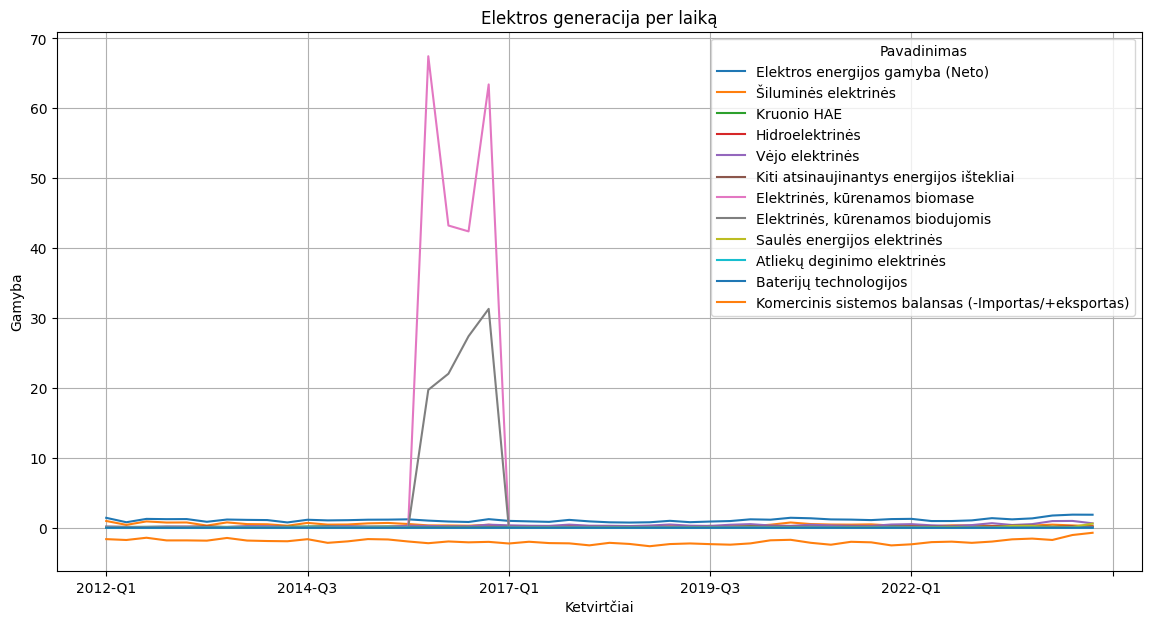

In [4]:
import matplotlib.pyplot as plt

df_Litgrid.T.plot(figsize=(14, 7))
plt.title('Elektros generacija per laiką')
plt.xlabel('Ketvirtčiai')
plt.ylabel('Gamyba')

plt.grid(True)
plt.show()

In [5]:
# Randu 'Outliers', reikia sutvarkyti:
df_Litgrid[['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2']]
threshold = 3.0 # Riba nuo kurios ieškomi 'Outliers'
mask = df_Litgrid.abs() > threshold
df_Litgrid[mask] = df_Litgrid[mask] / 1000

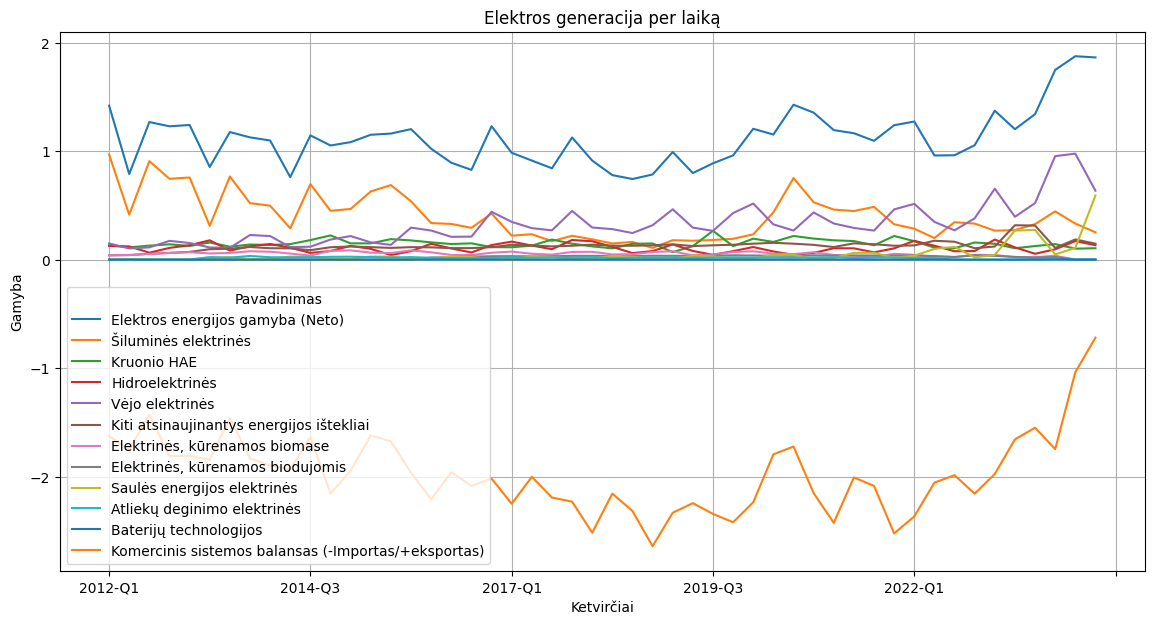

In [6]:
# Randu 'Outliers', reikia sutvarkyti:
df_Litgrid.T.plot(figsize=(14, 7))
plt.title('Elektros generacija per laiką')
plt.xlabel('Ketvirčiai')
plt.ylabel('Gamyba')

plt.grid(True)
plt.show()

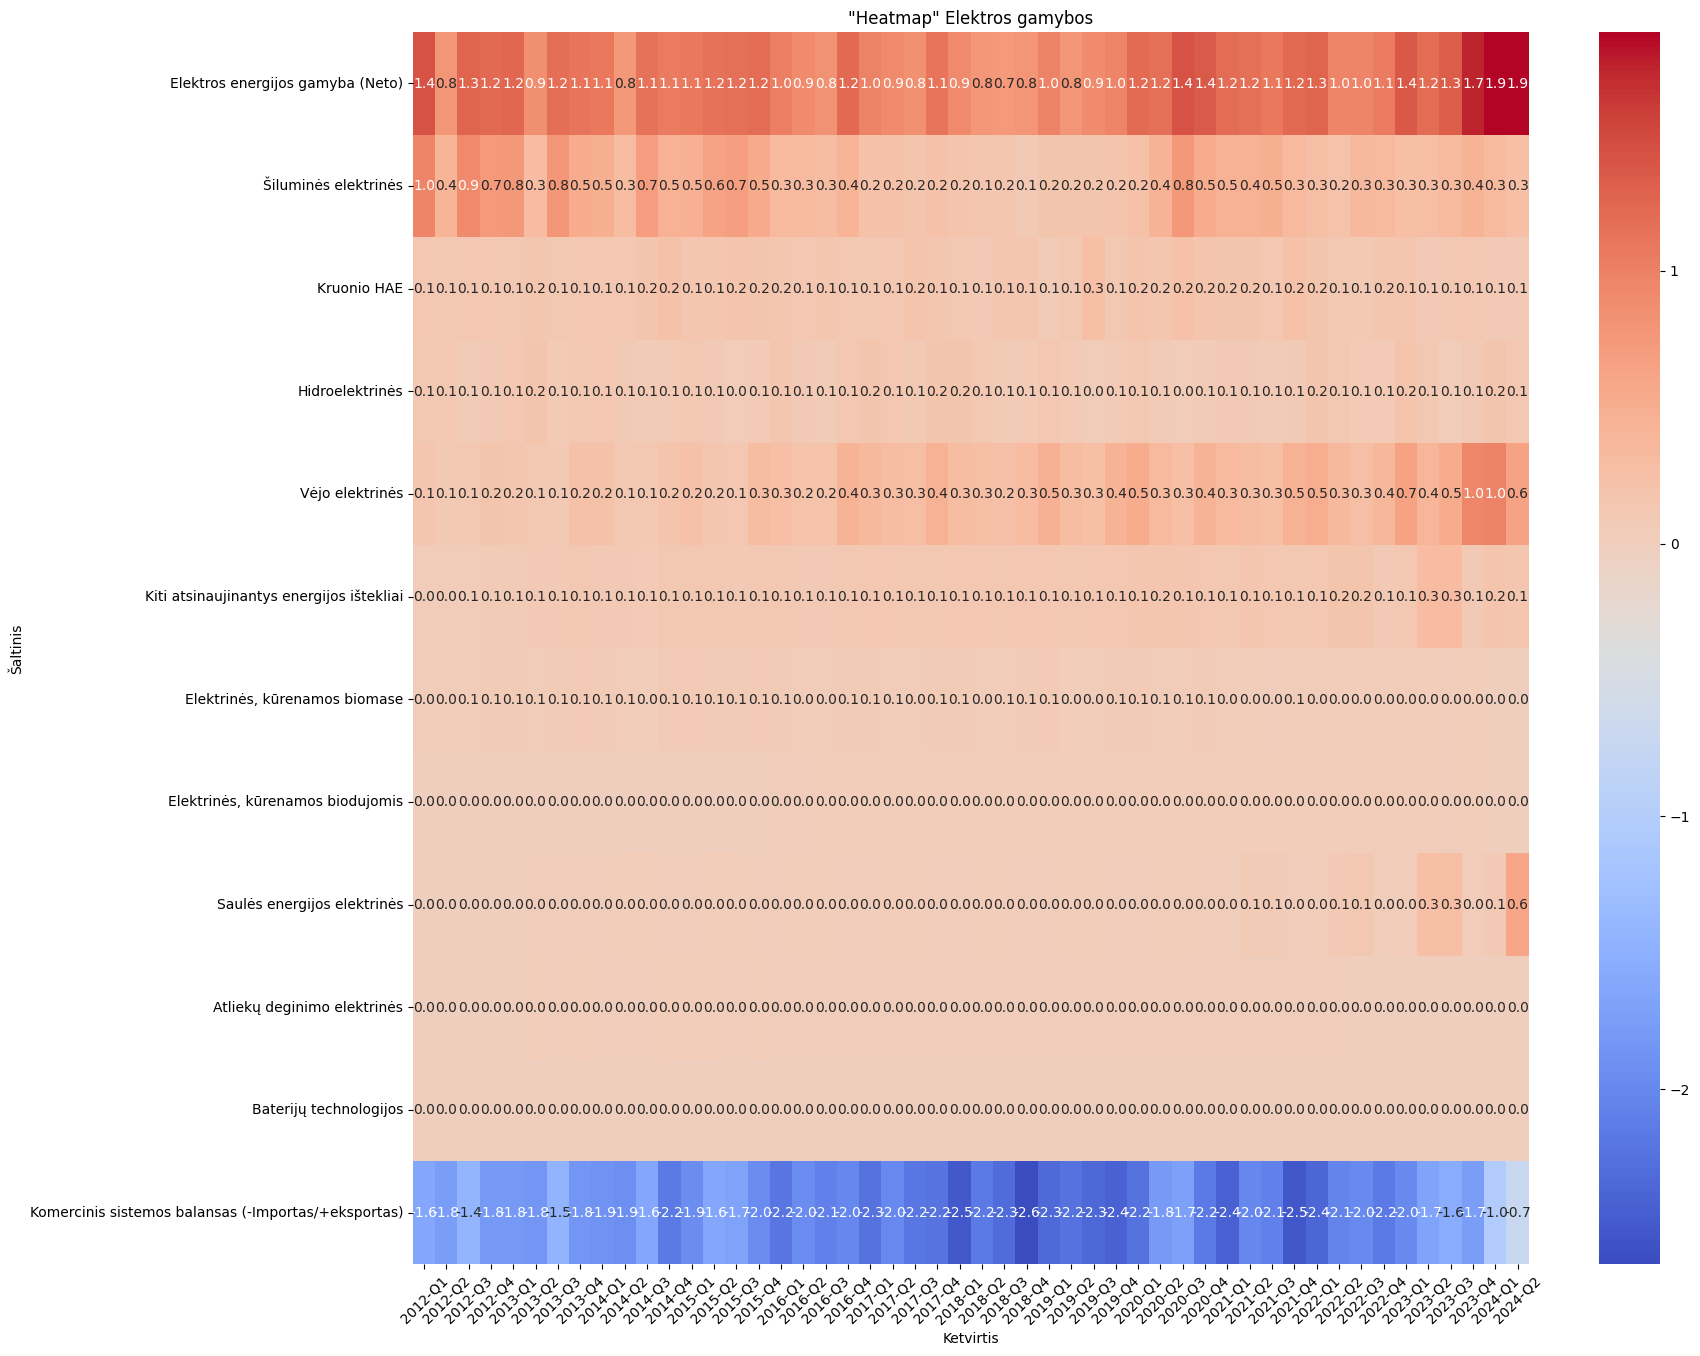

In [49]:
plt.figure(figsize=(18, 16))
sns.heatmap(df_Litgrid, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('"Heatmap" Elektros gamybos')
plt.xlabel('Ketvirtis')
plt.ylabel('Šaltinis')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

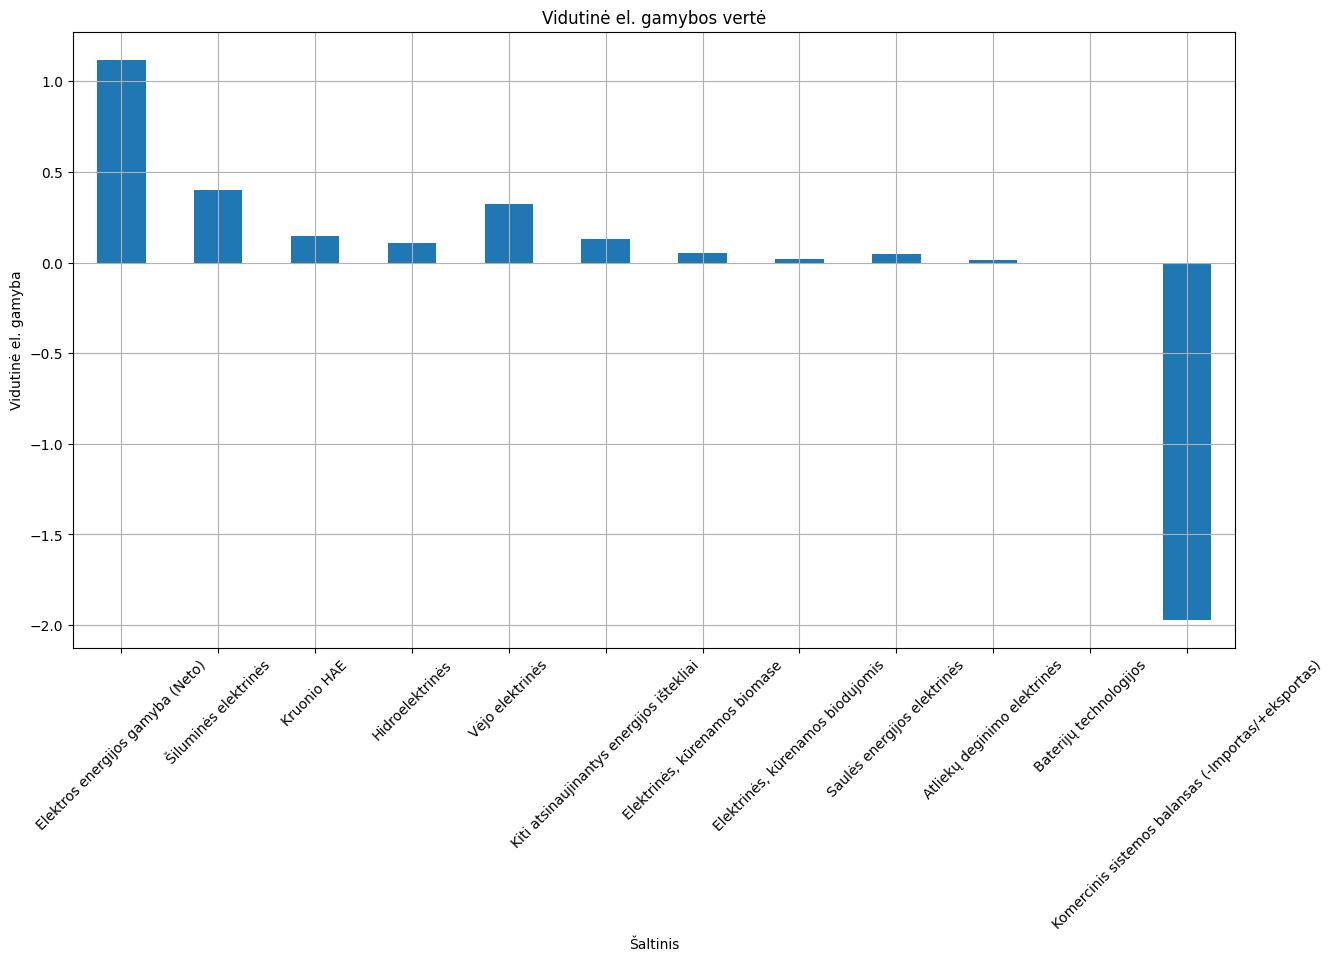

In [7]:
df_Litgrid.mean(axis=1).plot(kind='bar', figsize=(15, 8))
plt.title('Vidutinė el. gamybos vertė')
plt.xlabel('Šaltinis')
plt.ylabel('Vidutinė el. gamyba')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [51]:
# %pip install statsmodels

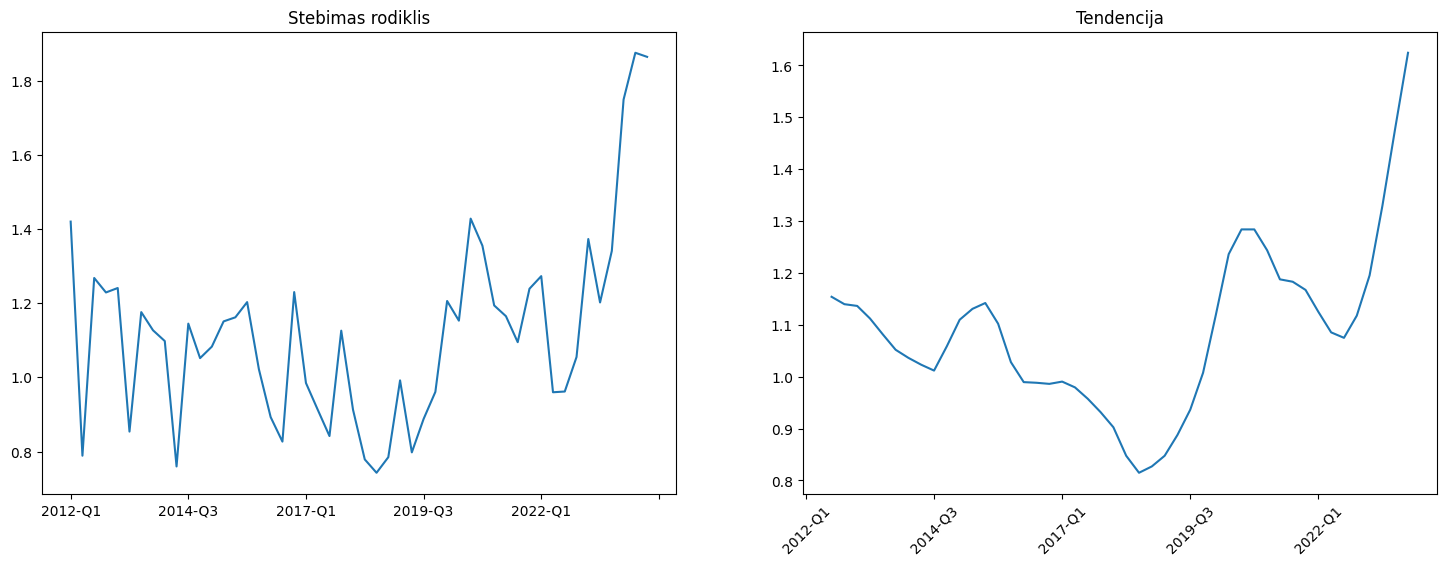

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_Litgrid.loc['Elektros energijos gamyba (Neto)']
decomposition = seasonal_decompose(ts, model='additive', period=4)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

decomposition.observed.plot(ax=axes[0], title='Stebimas rodiklis')
decomposition.trend.plot(ax=axes[1], title='Tendencija')
plt.xticks(rotation=45)
plt.show()

#### Kainų Grafikai ####

In [53]:
df_Elektra.head()

,Dieninė dedamoji,Naktinė dedamoji,Pastovioji dedamoji. EUR/mėn.,Viena laiko zona,Nord pool kaina,Metinė infliacija,Vidutinė Temperatūra C,Pagaminta elektra GWh
Data,,,,,,,,
2015-01,0.115,0.083,0.0,0.105,0.03978,-1.3,-0.38,0.357
2015-02,0.115,0.083,0.0,0.105,0.03944,-0.3,0.09,0.358
2015-03,0.115,0.083,0.0,0.105,0.03222,0.8,4.16,0.365
2015-04,0.115,0.083,0.0,0.105,0.03561,0.7,6.67,0.380
2015-05,0.115,0.083,0.0,0.105,0.03736,0.5,11.06,0.380


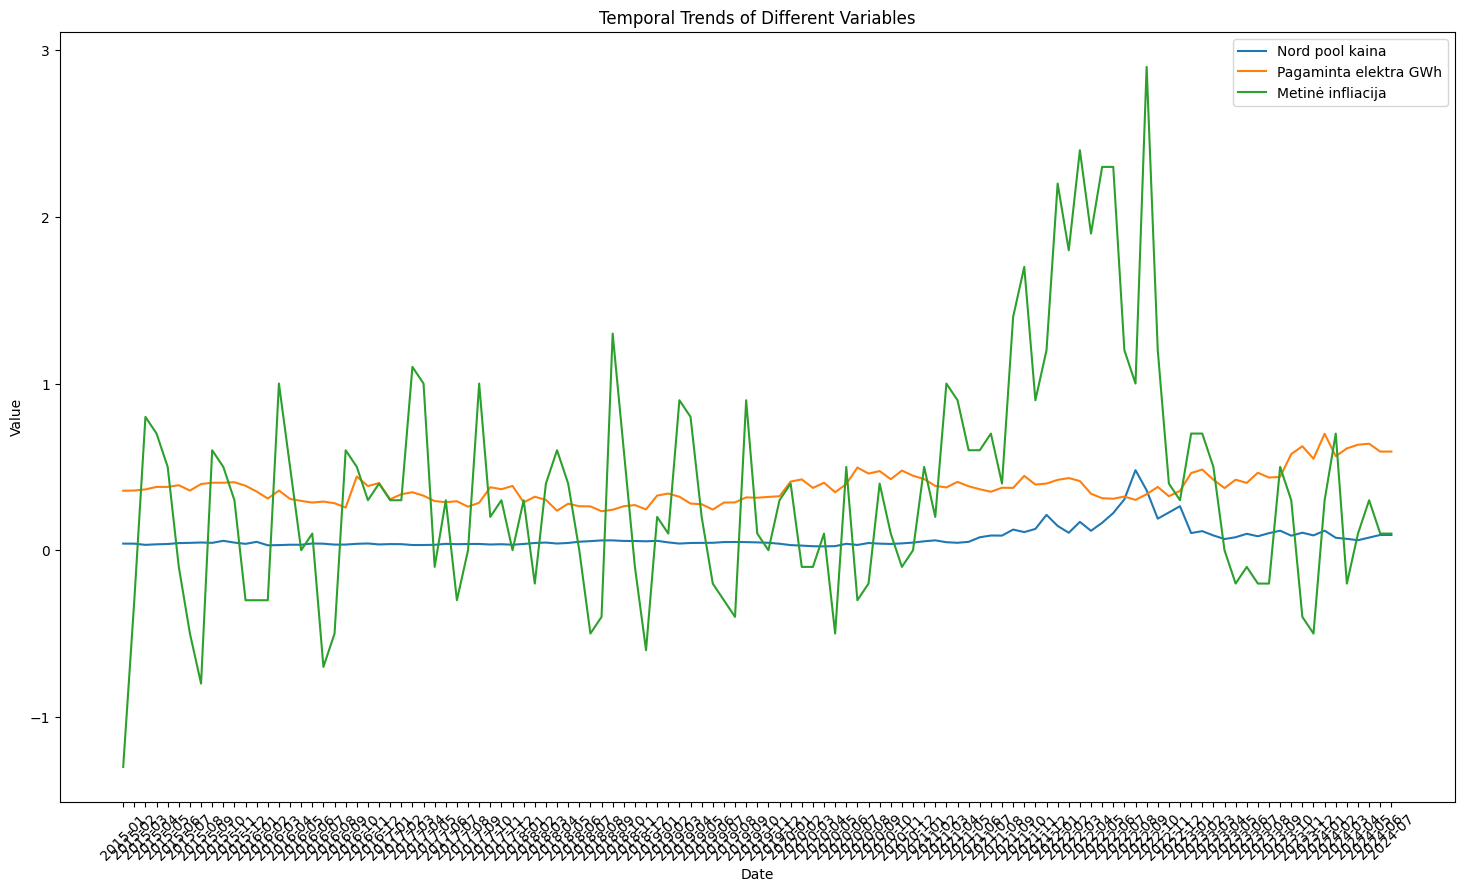

In [54]:
plt.figure(figsize=(18, 10))
sns.lineplot(data=df_Elektra, x='Data', y='Nord pool kaina', label='Nord pool kaina')
sns.lineplot(data=df_Elektra, x='Data', y='Pagaminta elektra GWh', label='Pagaminta elektra GWh')
sns.lineplot(data=df_Elektra, x='Data', y='Metinė infliacija', label='Metinė infliacija')
plt.legend()
plt.title('Temporal Trends of Different Variables')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

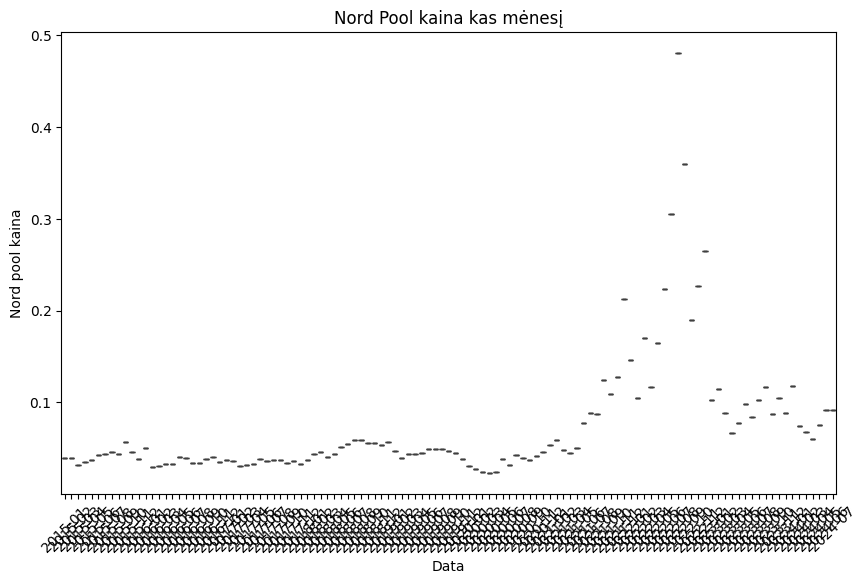

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_Elektra, x='Data', y='Nord pool kaina')
plt.title('Nord Pool kaina kas mėnesį')
plt.xlabel('Data')
plt.ylabel('Nord pool kaina')
plt.xticks(rotation=45)
plt.show()

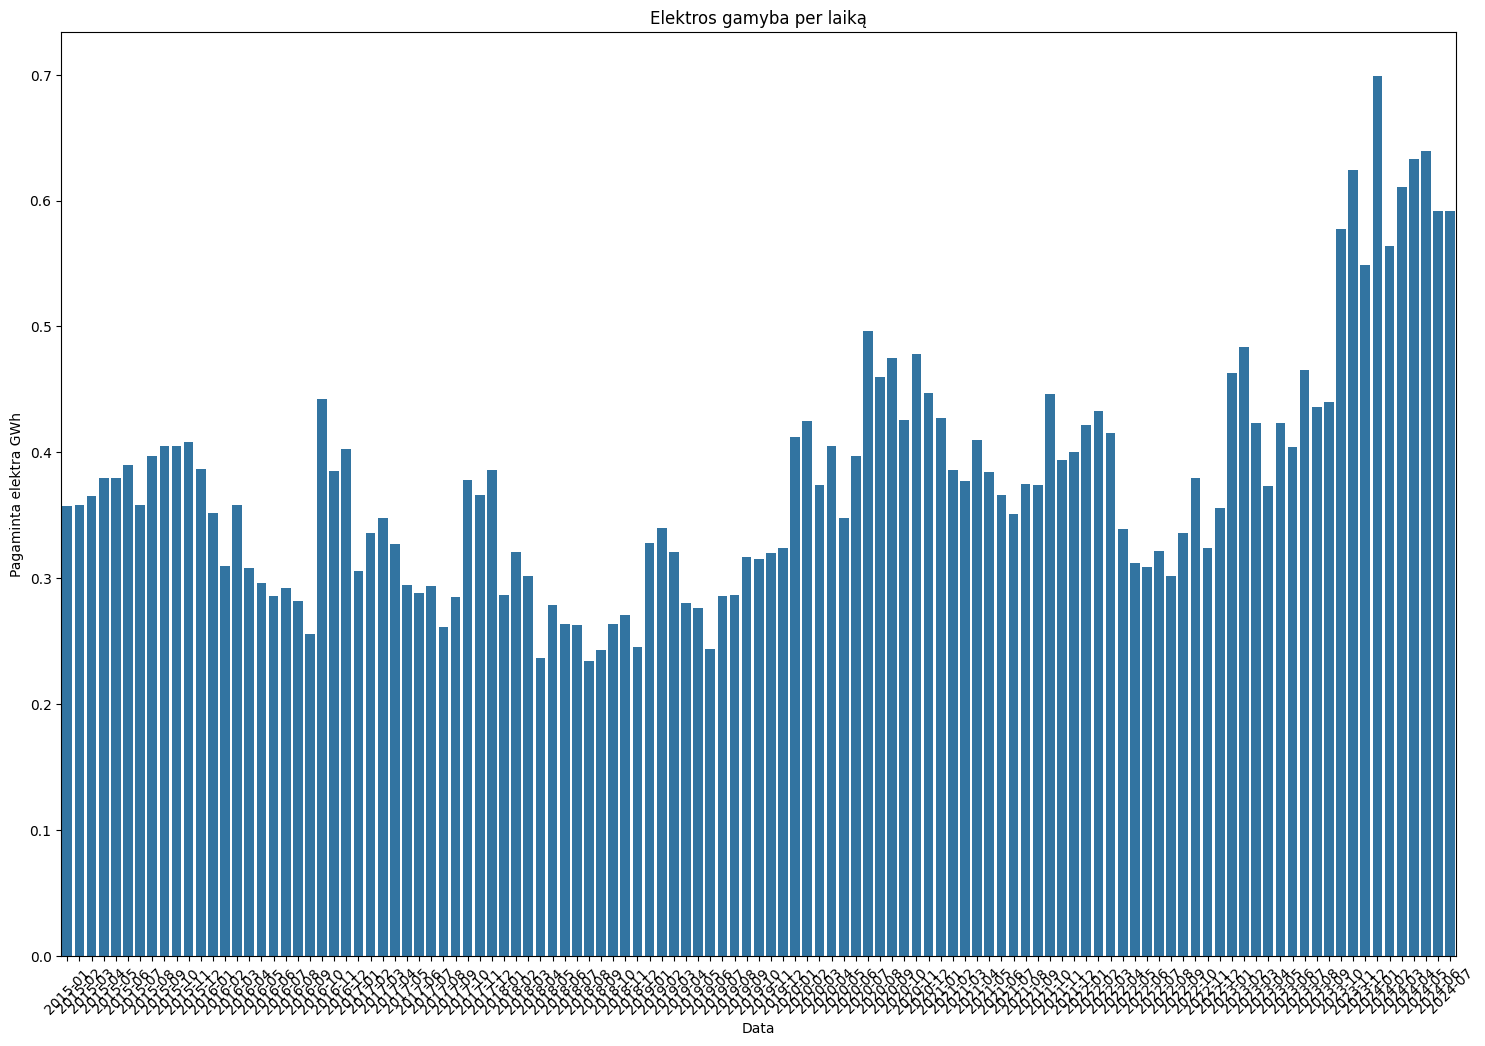

In [56]:
plt.figure(figsize=(18, 12))
sns.barplot(data=df_Elektra, x='Data', y='Pagaminta elektra GWh')
plt.title('Elektros gamyba per laiką')
plt.xlabel('Data')
plt.ylabel('Pagaminta elektra GWh')
plt.xticks(rotation=45)
plt.show()

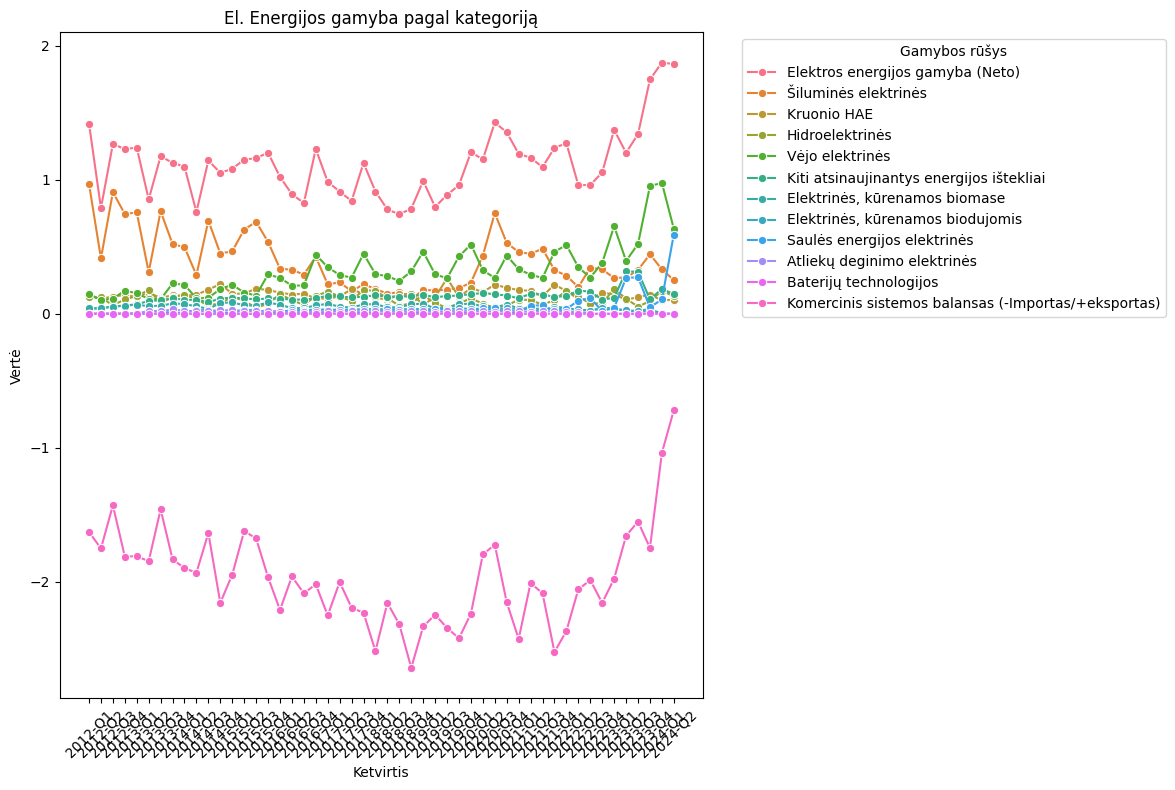

In [57]:
df_atvaizdavimui = df_Litgrid.reset_index().melt(id_vars='Pavadinimas', var_name='Ketvirtis', value_name='Vertė')

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_atvaizdavimui, x='Ketvirtis', y='Vertė', hue='Pavadinimas', marker='o')
plt.xticks(rotation=45)
plt.title('El. Energijos gamyba pagal kategoriją')
plt.xlabel('Ketvirtis')
plt.ylabel('Vertė')
plt.legend(title='Gamybos rūšys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [58]:
df_atvaizdavimui

,Pavadinimas,Ketvirtis,Vertė
0,Elektros energijos gamyba (Neto),2012-Q1,1.420
1,Šiluminės elektrinės,2012-Q1,0.969
2,Kruonio HAE,2012-Q1,0.131
3,Hidroelektrinės,2012-Q1,0.127
4,Vėjo elektrinės,2012-Q1,0.149
...,...,...,...
595,"Elektrinės, kūrenamos biodujomis",2024-Q2,0.000
596,Saulės energijos elektrinės,2024-Q2,0.592
597,Atliekų deginimo elektrinės,2024-Q2,0.000
598,Baterijų technologijos,2024-Q2,0.000


In [59]:
# df_atvaizdavimui.iloc[8:9, :]
# df_atvaizdavimui.to_csv('Pavadinimas.txt')

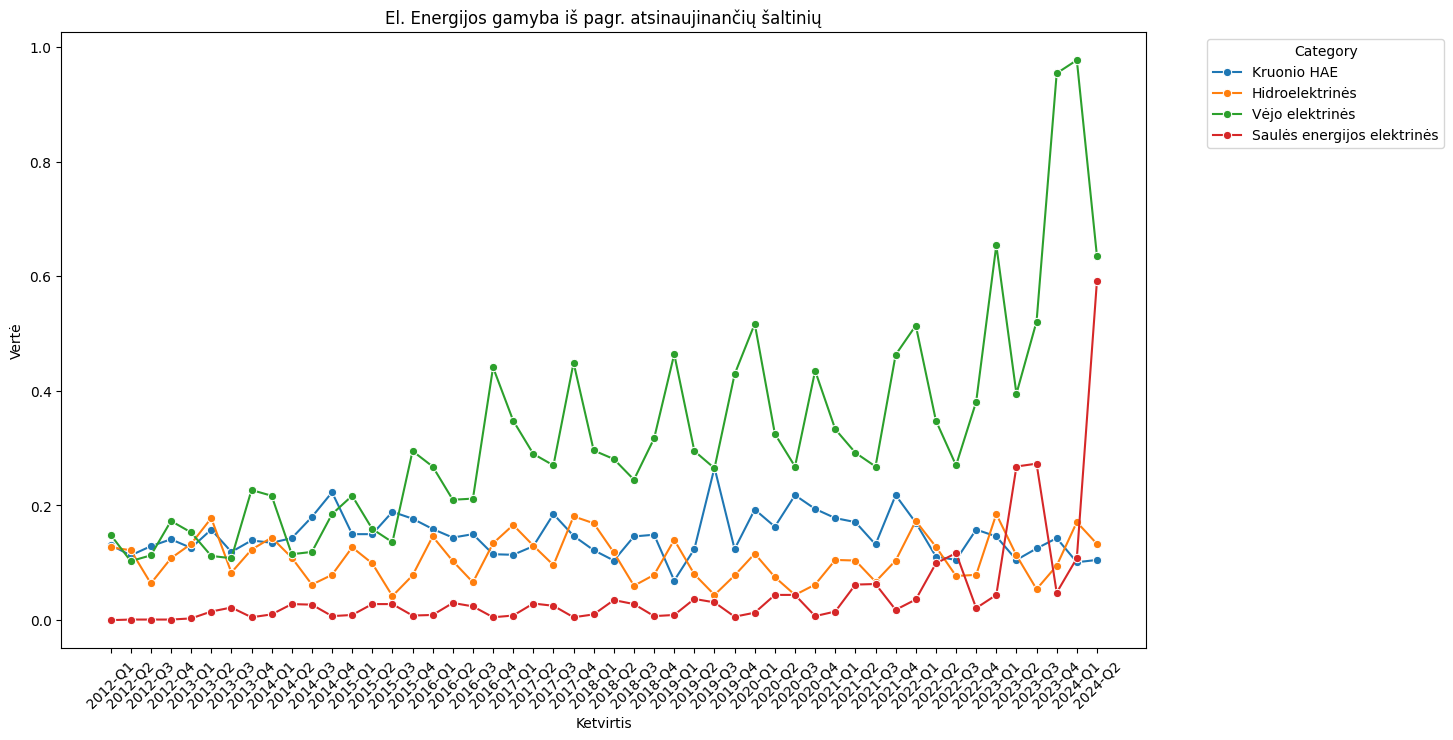

In [60]:
df_atsinaujinantys = df_atvaizdavimui[df_atvaizdavimui['Pavadinimas'].isin(['Saulės energijos elektrinės', 'Vėjo elektrinės', 'Hidroelektrinės', 'Kruonio HAE'])]

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_atsinaujinantys, x='Ketvirtis', y='Vertė', hue='Pavadinimas', marker='o')
plt.xticks(rotation=45)
plt.title('El. Energijos gamyba iš pagr. atsinaujinančių šaltinių')
plt.xlabel('Ketvirtis')
plt.ylabel('Vertė')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()